In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import warnings
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import ast
from nltk.tokenize import word_tokenize
import json
import random
from transformers import AutoTokenizer
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

warnings.filterwarnings("ignore")


train_data = pd.read_csv("train_data.csv")
train_data["target_labels_positions_conv"] = train_data["target_labels_positions"].apply(
    lambda x: ast.literal_eval(x)
)

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-06-08 07:51:18.581698: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 07:51:19.603466: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def preprocess_fred(text, label_dict):
    if len(label_dict) > 0:
        label = "Да, содержит"
        fin_list = []
        if "B-value" in label_dict:
            for i in label_dict["B-value"]:
                count = i
                item_list = []
                item_list.append(i)
                if "I-value" in label_dict:
                    for j in label_dict["I-value"]:
                        if j - 1 == count:
                            item_list.append(j)
                            count = j
                    fin_list.append(item_list)

        words = []
        tokens = word_tokenize(text)
        if len(fin_list) > 0:
            for list in fin_list:
                words_list = []
                for item in list:
                    word_item = tokens[item]
                    words_list.append(word_item)
                words_list_reworked = " ".join(words_list)
                words.append(words_list_reworked)

        discount_list = []
        if "B-discount" in label_dict:
            for i in label_dict["B-discount"]:
                word_discount = tokens[i]
                discount_list.append(word_discount)
        labels_reworked = {'label':label, 'value_words': words, 'discount_words': discount_list}
    else:
        label = "Нет, не содержит"
        labels_reworked = {"label": label, "value_words": [], "discount_words": []}
        
    return labels_reworked

In [4]:
train_data["labels_reworked"] = train_data[
    ["processed_text", "target_labels_positions_conv"]
].apply(
    lambda train_data: preprocess_fred(
        train_data["processed_text"], train_data["target_labels_positions_conv"]
    ),
    axis=1,
)
train_data

,processed_text,target_labels_positions,target_labels_positions_conv,labels_reworked
0,аа союзная тридцать пять дробь один лариса сое...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
1,аа приложение мне показывает к оплате у меня п...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
2,да лисное по призрак лишнее ну почему иду пять...,"{'I-value': [140], 'B-value': [139], 'B-discou...","{'I-value': [140], 'B-value': [139], 'B-discou...","{'label': 'Да, содержит', 'value_words': ['два..."
3,а что добрый день NAME у меня пришел какой то ...,{'B-discount': [12]},{'B-discount': [12]},"{'label': 'Да, содержит', 'value_words': [], '..."
4,у меня западный с утра да да еще да да самый в...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
...,...,...,...,...
3394,а доброе утро меня заинтересовала ваш проект н...,"{'I-value': [224, 225], 'B-value': [223], 'B-d...","{'I-value': [224, 225], 'B-value': [223], 'B-d...","{'label': 'Да, содержит', 'value_words': ['до ..."
3395,здравствуйте меня зовут иван я бы хотел сегодн...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
3396,целенаправлен на голосовой почтовый ящик вы мо...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."
3397,NAME зовут NAME я хотела уточнить ээ своего ме...,{},{},"{'label': 'Нет, не содержит', 'value_words': [..."


In [5]:
dataset = Dataset.from_pandas(train_data)
dataset

Dataset({
    features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked'],
    num_rows: 3399
})

In [6]:
def add_tags(example):

    tags = []
    new_dict = {}
    labels_dict = ast.literal_eval(example["target_labels_positions"])
    tags_index_list = [i[0] for i in labels_dict.values()]
    for key, value in labels_dict.items():
        for i in value:
            new_dict[i] = key
    for index, i in enumerate(word_tokenize(example["processed_text"])):
        if index in tags_index_list:
            if new_dict[index] == "B-discount":
                tags.append("B-discount")
            elif new_dict[index] == "B-value":
                tags.append("B-value")
            else:
                tags.append("I-value")
        else:
            tags.append("O")


    example["ner_tag"] = tags

    return example

In [7]:
added_tags_data = dataset.map(add_tags)
added_tags_data

Map: 100%|██████████| 3399/3399 [00:03<00:00, 961.64 examples/s] 


Dataset({
    features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag'],
    num_rows: 3399
})

In [8]:
added_tags_data = added_tags_data.shuffle()
train_test_split = added_tags_data.train_test_split(test_size=0.1)

In [9]:
def createCLASS_dataset(sample, prompts_file_path):
    """function to create classification dataset"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["CLASS"][str(num)]

    sample["aspect_ner_output"] = f"Ответ: \n{sample['labels_reworked']['label']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Классификация текста \n{instruction}\n{sample['processed_text']}\n"
    )
    return sample

In [10]:
CLASS_dataset = train_test_split["train"].map(
    createCLASS_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
CLASS_dataset[0]

Map: 100%|██████████| 3059/3059 [00:01<00:00, 2939.25 examples/s]


{'processed_text': 'здравствуйте актер а что вы хотите да да да мы с ним обменялись телефонами да все вкусдела все в порядке очень хорошо меня зовут NAME меня NAME зовут NAME всего доброго всего хорошего хороший рельтру понравился нам приятный вообще мне молодой человек он работает у вас да как бы это ваша агентств да да да да хорошо мы дальше будем поддерживать как бы связь разговаривать с ним и вести ээ как бы вот это вот как искать варианты алломеня зовут вероника служба контроля качество самолет плюс вам удобно вчера интересовали с недвижимостью по адресу улица ADDRESS манта один хотели уточнить нас агента NAME с планируется смотреть спасибо вам за удел прошу прощения а лена всего доброго даст все верно наш агент',
 'target_labels_positions': '{}',
 'target_labels_positions_conv': {'B-discount': None,
  'B-value': None,
  'I-value': None},
 'labels_reworked': {'discount_words': [],
  'label': 'Нет, не содержит',
  'value_words': []},
 'ner_tag': ['O',
  'O',
  'O',
  'O',
  'O',
  

In [11]:
def createDISC_dataset(sample, prompts_file_path):
    """function to create DISCOUNT_SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["DISC"][str(num)]
    sample["discount_list"] = ",".join([item for item in sample["labels_reworked"]['discount_words']])

    sample["aspect_ner_output"] = f"Ответ: \n{sample['discount_list']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск упоминания скидки \n{instruction}\nТекст: \n{sample['processed_text']}\n"
    )
    return sample

In [12]:
DISC_dataset = train_test_split["train"].map(
    createDISC_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
DISC_dataset[0]

Map: 100%|██████████| 3059/3059 [00:01<00:00, 2956.83 examples/s]


{'processed_text': 'здравствуйте актер а что вы хотите да да да мы с ним обменялись телефонами да все вкусдела все в порядке очень хорошо меня зовут NAME меня NAME зовут NAME всего доброго всего хорошего хороший рельтру понравился нам приятный вообще мне молодой человек он работает у вас да как бы это ваша агентств да да да да хорошо мы дальше будем поддерживать как бы связь разговаривать с ним и вести ээ как бы вот это вот как искать варианты алломеня зовут вероника служба контроля качество самолет плюс вам удобно вчера интересовали с недвижимостью по адресу улица ADDRESS манта один хотели уточнить нас агента NAME с планируется смотреть спасибо вам за удел прошу прощения а лена всего доброго даст все верно наш агент',
 'target_labels_positions': '{}',
 'target_labels_positions_conv': {'B-discount': None,
  'B-value': None,
  'I-value': None},
 'labels_reworked': {'discount_words': [],
  'label': 'Нет, не содержит',
  'value_words': []},
 'ner_tag': ['O',
  'O',
  'O',
  'O',
  'O',
  

In [13]:
def createVAL_dataset(sample, prompts_file_path):
    """function to create VALUE_SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["VAL"][str(num)]

    sample["discount_list"] = ",".join(
        [item for item in sample["labels_reworked"]["discount_words"]]
    )
    sample["value_list"] = ",".join(
        [item for item in sample["labels_reworked"]["value_words"]]
    )

    sample["aspect_ner_output"] = f"Ответ: \n{sample['value_list']}</s>"
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск размера скидки \n{instruction}\nТекст: \n{sample['processed_text']}\nУпомянутые в тексте скидки:{sample['discount_list']}"
    )
    return sample

In [14]:
VAL_dataset = train_test_split["train"].map(
    createVAL_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
VAL_dataset[300]

Map: 100%|██████████| 3059/3059 [00:01<00:00, 2944.58 examples/s]


{'processed_text': 'здравствуйте да директор мне нужно крем связаться с менеджером мужика манжаниного мне просто ведь конец никак не перезвонит можете запрос позда пожалуйста сделать чтобы мне позвонили чтобы поговорить с менеджером и хотел бы там обсудить вопрос киски и брони квартиру уже подобрали а здравствуйте это на месте дивя да смотрите я я смотрите смотрите я агент мы с клиентом подобрали квартиру молжаренного я уже уникалью просто через агрегатория ну если мне никак не перезванивает никто самозаниного а мне бы хотелось уже говорить ну какая скидка могут предоставить если покупаем по определенном условиям и не забронировать давайте что скажу не консультацию никогда я ничего не узнаю я просто номер телефона у меня просто отмолзае с двух старых метров у которых там же не работал и поэтому я не знаю кому звонить из за этого соответственно мне просто обдавать их вопросы что делать да номер клиента девятьсот один пятьсот четыре девяносто два семь дадобрый день группу самолета на зап

In [15]:
def createVAL_FIN_dataset(sample, prompts_file_path):
    """function to create DISCOUNT and VALUE SEARCH"""
    with open(prompts_file_path, encoding="UTF-8") as fp:
        template = json.load(fp)

    num = random.randint(1, len(template))
    instruction = template["ALL"][str(num)]

    sample["discount_list"] = ",".join(
        [item for item in sample["labels_reworked"]["discount_words"]]
    )
    sample["value_list"] = ",".join(
        [item for item in sample["labels_reworked"]["value_words"]]
    )

    sample["aspect_ner_output"] = (
        f"Ответ: \n{sample['discount_list']}:{sample['value_list']}</s>"
    )
    sample["aspect_ner_input"] = (
        f"<LM>Задача: Поиск упоминания скидки и ее размера\n{instruction}\nТекст: \n{sample['processed_text']}\n"
    )
    return sample

In [16]:
VAL_FINdataset = train_test_split["train"].map(
    createVAL_FIN_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)
VAL_FINdataset[300]

Map: 100%|██████████| 3059/3059 [00:01<00:00, 2913.38 examples/s]


{'processed_text': 'здравствуйте да директор мне нужно крем связаться с менеджером мужика манжаниного мне просто ведь конец никак не перезвонит можете запрос позда пожалуйста сделать чтобы мне позвонили чтобы поговорить с менеджером и хотел бы там обсудить вопрос киски и брони квартиру уже подобрали а здравствуйте это на месте дивя да смотрите я я смотрите смотрите я агент мы с клиентом подобрали квартиру молжаренного я уже уникалью просто через агрегатория ну если мне никак не перезванивает никто самозаниного а мне бы хотелось уже говорить ну какая скидка могут предоставить если покупаем по определенном условиям и не забронировать давайте что скажу не консультацию никогда я ничего не узнаю я просто номер телефона у меня просто отмолзае с двух старых метров у которых там же не работал и поэтому я не знаю кому звонить из за этого соответственно мне просто обдавать их вопросы что делать да номер клиента девятьсот один пятьсот четыре девяносто два семь дадобрый день группу самолета на зап

In [17]:
FIN_test = train_test_split["test"].map(
    createVAL_FIN_dataset, fn_kwargs={"prompts_file_path": "prompts_joint_samolet.json"}
)

Map: 100%|██████████| 340/340 [00:00<00:00, 2802.51 examples/s]


In [18]:
from datasets import concatenate_datasets

combined_datasets = concatenate_datasets(
    [CLASS_dataset, DISC_dataset, VAL_dataset, VAL_FINdataset],
)
combined_datasets = combined_datasets.shuffle()
dataset_train_test = combined_datasets.train_test_split(test_size=0.1)
final_ds = DatasetDict(
    {
        "train": dataset_train_test["train"],
        "test": dataset_train_test["test"],
        "val": FIN_test,
    }
)

In [19]:
final_ds

DatasetDict({
    train: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'aspect_ner_output', 'aspect_ner_input', 'discount_list', 'value_list'],
        num_rows: 11012
    })
    test: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'aspect_ner_output', 'aspect_ner_input', 'discount_list', 'value_list'],
        num_rows: 1224
    })
    val: Dataset({
        features: ['processed_text', 'target_labels_positions', 'target_labels_positions_conv', 'labels_reworked', 'ner_tag', 'discount_list', 'value_list', 'aspect_ner_output', 'aspect_ner_input'],
        num_rows: 340
    })
})

In [20]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/FRED-T5-large")
tokenized_inputs = concatenate_datasets(
    [
        final_ds["train"],
        final_ds["test"],
        final_ds["val"],
    ],
).map(
    lambda x: tokenizer(x["aspect_ner_input"], truncation=True),
    batched=True,
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Map: 100%|██████████| 12576/12576 [00:02<00:00, 5752.09 examples/s]


In [21]:
tokenized_targets = concatenate_datasets(
    [
        final_ds["train"],
        final_ds["test"],
        final_ds["val"],
    ],
).map(
    lambda x: tokenizer(x["aspect_ner_output"], truncation=True),
    batched=True,
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])

Map: 100%|██████████| 12576/12576 [00:00<00:00, 50924.72 examples/s]


In [22]:
def tokenize_function(
    sample, tokenizer, max_source_length, max_target_length, padding="max_length"
):
    """function to tokenize data for FLAN"""
    model_inputs = tokenizer(
        sample["aspect_ner_input"],
        max_length=max_source_length,
        padding=padding,
        truncation=True,
    )
    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(
        text_target=sample["aspect_ner_output"],
        max_length=max_target_length,
        padding=padding,
        truncation=True,
    )
    # If we are padding here, replace all tokenizer.pad_token_id in the labels
    # by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label]
            for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
tokenized_dataset = final_ds.map(
    tokenize_function,
    batched=True,
    fn_kwargs={
        "max_source_length": max_source_length,
        "max_target_length": max_target_length,
        "tokenizer": tokenizer,
    },
    remove_columns=[
        "processed_text",
        "target_labels_positions",
        "target_labels_positions_conv",
        "labels_reworked",
        "ner_tag",
        "discount_list",
        "value_list",
        "aspect_ner_output",
        "aspect_ner_input",
    ],
)

Map: 100%|██████████| 340/340 [00:00<00:00, 2079.20 examples/s]


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained("ai-forever/FRED-T5-large")
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8,
)

In [25]:
repository_id = f"fred-test"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    fp16=False,  # Overflows with fp16
    learning_rate=1e-4,
    num_train_epochs=5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    optim="adamw_torch",
    # logging & evaluation strategies
    evaluation_strategy="epoch",
    save_strategy="no",
    save_total_limit=1,
    push_to_hub=False,
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
trainer.train()

  7%|▋         | 500/6885 [11:38<2:28:40,  1.40s/it]

{'loss': 0.8714, 'grad_norm': 1.6466163396835327, 'learning_rate': 7.256894049346879e-05, 'epoch': 0.36}


 15%|█▍        | 1000/6885 [23:17<2:17:03,  1.40s/it]

{'loss': 0.0933, 'grad_norm': 22.107921600341797, 'learning_rate': 9.49806326662363e-05, 'epoch': 0.73}


 99%|█████████▉| 152/153 [01:08<00:00,  2.19it/s]
                                                     
100%|██████████| 153/153 [01:09<00:00,  2.20it/s]
                                                 

{'eval_loss': 0.08091054111719131, 'eval_runtime': 69.9084, 'eval_samples_per_second': 17.509, 'eval_steps_per_second': 2.189, 'epoch': 1.0}


 22%|██▏       | 1500/6885 [36:05<2:05:19,  1.40s/it] 

{'loss': 0.0737, 'grad_norm': 0.5192190408706665, 'learning_rate': 8.69109102646869e-05, 'epoch': 1.09}


 29%|██▉       | 2000/6885 [47:43<1:53:27,  1.39s/it]

{'loss': 0.056, 'grad_norm': 0.564294159412384, 'learning_rate': 7.884118786313751e-05, 'epoch': 1.45}


 36%|███▋      | 2500/6885 [59:20<1:41:51,  1.39s/it]

{'loss': 0.0564, 'grad_norm': 0.6408737897872925, 'learning_rate': 7.077146546158813e-05, 'epoch': 1.82}


 99%|█████████▉| 152/153 [01:08<00:00,  2.19it/s]
                                                       
100%|██████████| 153/153 [01:09<00:00,  2.20it/s]
                                                 

{'eval_loss': 0.06399759650230408, 'eval_runtime': 69.9088, 'eval_samples_per_second': 17.509, 'eval_steps_per_second': 2.189, 'epoch': 2.0}


 44%|████▎     | 3000/6885 [1:12:07<1:30:18,  1.39s/it] 

{'loss': 0.0443, 'grad_norm': 0.33289751410484314, 'learning_rate': 6.270174306003875e-05, 'epoch': 2.18}


 51%|█████     | 3500/6885 [1:23:44<1:18:40,  1.39s/it]

{'loss': 0.04, 'grad_norm': 0.006575292907655239, 'learning_rate': 5.4632020658489345e-05, 'epoch': 2.54}


 58%|█████▊    | 4000/6885 [1:35:22<1:07:03,  1.39s/it]

{'loss': 0.0421, 'grad_norm': 0.503903329372406, 'learning_rate': 4.6562298256939964e-05, 'epoch': 2.9}


 99%|█████████▉| 152/153 [01:09<00:00,  2.19it/s]
                                                     
 60%|██████    | 4131/6885 [1:39:34<55:30,  1.21s/it]

{'eval_loss': 0.048829756677150726, 'eval_runtime': 69.9653, 'eval_samples_per_second': 17.494, 'eval_steps_per_second': 2.187, 'epoch': 3.0}



 65%|██████▌   | 4500/6885 [1:48:09<55:25,  1.39s/it]   

{'loss': 0.0333, 'grad_norm': 0.7501568794250488, 'learning_rate': 3.849257585539058e-05, 'epoch': 3.27}


 73%|███████▎  | 5000/6885 [1:59:46<43:49,  1.39s/it]

{'loss': 0.0275, 'grad_norm': 1.6589312553405762, 'learning_rate': 3.042285345384119e-05, 'epoch': 3.63}


 80%|███████▉  | 5500/6885 [2:11:24<32:11,  1.39s/it]

{'loss': 0.0247, 'grad_norm': 0.6501432061195374, 'learning_rate': 2.2353131052291805e-05, 'epoch': 3.99}


 99%|█████████▉| 152/153 [01:09<00:00,  2.19it/s]
                                                     
100%|██████████| 153/153 [01:09<00:00,  2.20it/s]
                                                 

{'eval_loss': 0.03432629629969597, 'eval_runtime': 69.9677, 'eval_samples_per_second': 17.494, 'eval_steps_per_second': 2.187, 'epoch': 4.0}


 87%|████████▋ | 6000/6885 [2:24:11<20:34,  1.39s/it]  

{'loss': 0.0175, 'grad_norm': 1.8236503601074219, 'learning_rate': 1.4283408650742416e-05, 'epoch': 4.36}


 94%|█████████▍| 6500/6885 [2:35:48<08:56,  1.39s/it]

{'loss': 0.0203, 'grad_norm': 0.48124971985816956, 'learning_rate': 6.213686249193028e-06, 'epoch': 4.72}


 99%|█████████▉| 152/153 [01:09<00:00,  2.19it/s]
                                                     
100%|██████████| 6885/6885 [2:45:55<00:00,  1.45s/it]

{'eval_loss': 0.032040514051914215, 'eval_runtime': 69.9579, 'eval_samples_per_second': 17.496, 'eval_steps_per_second': 2.187, 'epoch': 5.0}
{'train_runtime': 9955.3032, 'train_samples_per_second': 5.531, 'train_steps_per_second': 0.692, 'train_loss': 0.10271336777797192, 'epoch': 5.0}


TrainOutput(global_step=6885, training_loss=0.10271336777797192, metrics={'train_runtime': 9955.3032, 'train_samples_per_second': 5.531, 'train_steps_per_second': 0.692, 'total_flos': 1.7070252618940416e+17, 'train_loss': 0.10271336777797192, 'epoch': 5.0})

In [26]:
def convert_prediction_to_tags(text, prediction):
    tokens = word_tokenize(text)
    if ":" in prediction:
        discounts_predicted = prediction.split(':')[0]
        values_predicted = prediction.split(':')[1]
    else:
        discounts_predicted = ''
        values_predicted = ''
    list = [i for i in values_predicted.split(',')]
    b_values = []
    i_values = []
    for item in list:
        item_list = item.split(' ')
        if len(item_list) > 0:
            for j, _ in enumerate(tokens):
                if tokens[j:len(item_list)+j] == item_list:
                    b_values.append(j)
                    end = len(item_list) + j
                    for k in range(end-j):
                        i_values.append(end)
                        end -= 1
                        if end != j:
                            continue
    tags = []
    for word in tokens:
        if word in discounts_predicted.split(','):
            tags.append('B-discount')
        elif tokens.index(word) in b_values:
            tags.append('B-value')
        elif tokens.index(word) in i_values:
            tags.append('I-value')
        else:
            tags.append('O')  

    return tags                     

In [29]:
import torch
device = torch.device("cuda")


def generate_response(
    model, tokenizer, question, top_p, temperature, prompts_path, device
):
    """function to generate response from FLAN models"""
    with open(prompts_path, encoding="UTF-8") as fp:
        template = json.load(fp)
    num = random.randint(1, len(template))
    instruction = template["ALL"][str(num)]
    input = f"<LM>Задача: Поиск упоминания скидки и ее размера\n{instruction}\n{question}\n"
    input_ids = tokenizer.encode(input, return_tensors="pt")
    sample_output = model.generate(
        input_ids=input_ids.to(device),
        do_sample=True,
        max_length=100,
        top_p=top_p,
        temperature=temperature,
        top_k=70,
        early_stopping=True,
        # no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id,
    )
    out = tokenizer.decode(sample_output[0][1:], skip_special_tokens=True)
    if "</s>" in out:
        out = out[: out.find("</s>")].strip()

    out = out.split("Ответ:")[1].strip().replace(": ", ":").replace('_', '')
    return out

In [30]:
from tqdm import tqdm
predictions = []
for item in tqdm(final_ds['val']):
    answer = generate_response(
        model=model,
        tokenizer=tokenizer,
        question=item["processed_text"],
        top_p=0.6,
        temperature=0.7,
        prompts_path='prompts_joint_samolet.json',
        device=device,
    )
    tag_list = convert_prediction_to_tags(item["processed_text"], answer)
    new_line = {"processed_text": item["processed_text"], 'label':tag_list}
    predictions.append(new_line)

100%|██████████| 340/340 [01:16<00:00,  4.46it/s]


In [31]:
y_true_list = [i for i in final_ds["val"]["ner_tag"]]
len(y_true_list)

340

In [32]:
true_flat = []
for item in y_true_list:
    true_flat.extend(item)
len(true_flat)


85745

In [33]:
pred_falt = []
for item in predictions:
    pred_falt.extend(item['label'])
len(pred_falt)

85745

In [34]:
weights = {'B-discount':1, 'B-value':2, 'I-value':2, 'O':0.003}

In [35]:
from sklearn.metrics import precision_recall_fscore_support

def weighted_f1(y_true, y_pred, weights):
    """Расчет взвешенной F1 меры с индивидуальными весами для классов."""

    # рассчитываем F1 для всех классов
    _, _, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=list(weights.keys())
    )

    # вычисление взвешенной F-меры
    weighted_f1 = np.sum(
        f1
        * [weights[label] for label in np.unique(y_true + y_pred)]
        * support
    ) / np.sum(
        support * [weights[label] for label in np.unique(y_true + y_pred)]
    )
    return weighted_f1

weighted_f1_score = weighted_f1(true_flat, pred_falt, weights)
print(weighted_f1_score)

0.7159329401491866


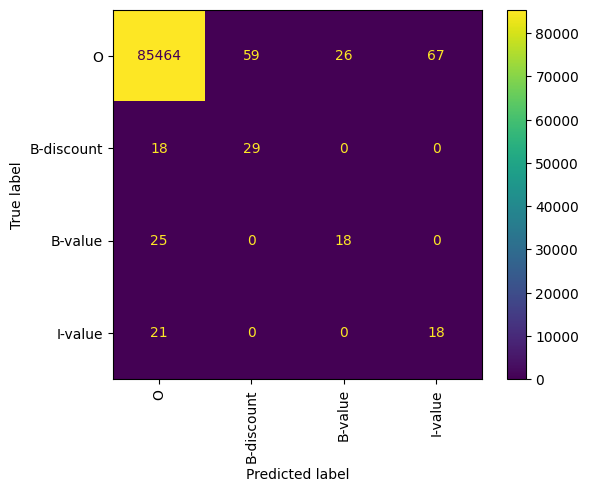

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
label_list = ["O", "B-discount", "B-value", "I-value"]

cm = confusion_matrix(true_flat, pred_falt, labels=label_list)
cm_display = ConfusionMatrixDisplay(cm, display_labels=label_list)
cm_display.plot(xticks_rotation="vertical")
plt.show()

In [38]:
model.save_pretrained("./results/samolet_fred")
tokenizer.save_pretrained("./results/samolet_fred")

('./results/samolet_fred/tokenizer_config.json',
 './results/samolet_fred/special_tokens_map.json',
 './results/samolet_fred/vocab.json',
 './results/samolet_fred/merges.txt',
 './results/samolet_fred/added_tokens.json',
 './results/samolet_fred/tokenizer.json')

In [37]:
from sklearn.metrics import classification_report

print(
    classification_report(true_flat, pred_falt, labels=label_list,
    )
)

              precision    recall  f1-score   support

           O       1.00      1.00      1.00     85616
  B-discount       0.33      0.62      0.43        47
     B-value       0.41      0.42      0.41        43
     I-value       0.21      0.46      0.29        39

    accuracy                           1.00     85745
   macro avg       0.49      0.62      0.53     85745
weighted avg       1.00      1.00      1.00     85745

